In [53]:
import sys
sys.path.append("/Users/santy/Google Drive/github projects/questaal-reader")
from questaal_reader import get_bands
from pymatgen.electronic_structure.plotter import BSPlotter as bp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.lines import Line2D
# from adjustText import adjust_text
import re
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
from tabulate import tabulate
from scipy.interpolate import Rbf
from pysciplottk.easyplotter import EasyPlotter

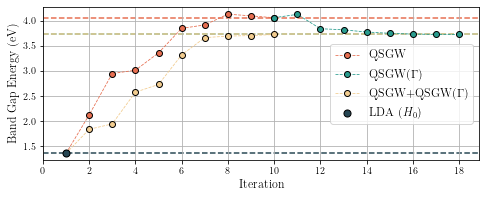

In [61]:
qsgw_gaps=[ 0.86775,2.14079,2.96963,3.03577,3.38354,3.87479,3.94376,4.15942,4.12516,4.08735]
qsgw_gaps=np.array(qsgw_gaps)
qsgw_gaps=4.13*qsgw_gaps/qsgw_gaps.max()
qsgw_gaps[0]=1.36
qsgwg_gaps=[4.07935,4.16731,3.87848,3.85641,3.81144,3.78663,3.77044,3.76340,3.76254]
qsgwg_gaps=np.array(qsgwg_gaps)
qsgwg_gaps=3.7256*qsgwg_gaps/qsgwg_gaps.min()
qsgwg_gaps[0]=qsgw_gaps[-1]
x_qsgw=(np.arange(len(qsgw_gaps))+1)

bse_scratch=[0.94692,1.86497,1.97390,2.61441,2.76954,3.36633,3.71549,3.74655,3.75738,3.77887]
bse_scratch=np.array(bse_scratch)
bse_scratch=3.7256*bse_scratch/bse_scratch.max()
bse_scratch[0]=1.36

fig,ax=plt.subplots(figsize=(7,3))
plt.rc('legend',**{'fontsize':12})
ax.plot(x_qsgw,qsgw_gaps,marker="o",ls="--",lw=.8,label="QSGW",c="#e76f51",markerfacecolor="#e76f51",markeredgecolor='k')
ax.axhline(qsgw_gaps[-1],ls="--",c="#e76f51",zorder=-3)

x=x_qsgw[-1]+np.arange(len(qsgwg_gaps))
ax.plot(x,qsgwg_gaps,marker="o",ls="--",lw=.8,label="QSGW($\\Gamma$)",c="#2a9d8f",markerfacecolor="#2a9d8f",markeredgecolor='k')
ax.axhline(qsgwg_gaps[-1],c="#2a9d8f",ls="--",zorder=-3)

ax.scatter(1,qsgw_gaps[0],s=50,c="#264653",label="LDA ($H_0$)",zorder=10,edgecolors='k')
ax.axhline(qsgw_gaps[0],c="#264653",ls="--",zorder=-3)

ax.plot(np.arange(len(bse_scratch))+1,bse_scratch,marker="o",ls="--",lw=.8,label="QSGW+QSGW($\\Gamma$)",c="#f2cc8f",markerfacecolor="#f2cc8f",markeredgecolor='k')
ax.axhline(bse_scratch[-1],c="#f2cc8f",ls="--",zorder=-3)

ax.legend()
ax.grid()
ax.set_ylabel("Band Gap Energy (eV)")
ax.set_xlabel("Iteration")
ax.set_xticks(np.arange(20)[::2])
plt.tight_layout()
plt.savefig("figs/bandgaps.pdf",dpi=300)
plt.show()

In [57]:
p_gw=get_bands("data/bnds_gw.temp",coords_are_cartesian=False)
p_bse=get_bands("data/bnds_bse.temp",coords_are_cartesian=False)
p_lda=get_bands("data/bnds_LDA.temp",coords_are_cartesian=False)
for i in [p_gw,
p_bse,p_lda]: 
    i.efermi=list(i.bands.values())[0][10].max()
# p_gw_ladder.efermi=np.max(list(p_gw_ladder.bands.values())[0][10])
# p_gw.efermi=np.max(list(p_gw.bands.values())[0][10])
# p_lda.efermi=np.max(list(p_lda.bands.values())[0][10])

In [42]:


data={}
label=["GGA","QSGW","QSGW $\Gamma$"]
data[" "]=["Gap (eV)","CBM k-point","VBM k-point"]
for j,i in enumerate([p_lda,p_gw,p_bse]):
    cbm=i.get_cbm()['kpoint'].frac_coords
    vbm=i.get_vbm()['kpoint'].frac_coords
    gap=i.get_direct_band_gap()
    vbm="("+",".join(["{:.3f}".format(i) for i in vbm])+")"
    cbm="("+",".join(["{:.3f}".format(i) for i in cbm])+")"
    data[label[j]]=["{:.3f}".format(gap),cbm,vbm]
    
print(tabulate(data,headers="keys",tablefmt="fancy_grid"))
print(tabulate(data,headers="keys",tablefmt="latex"))

╒═════════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│             │ GGA                 │ QSGW                │ QSGW $\Gamma$       │
╞═════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ Gap (eV)    │ 1.431               │ 4.720               │ 4.298               │
├─────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ CBM k-point │ (0.612,0.388,0.500) │ (0.604,0.396,0.500) │ (0.604,0.396,0.500) │
├─────────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ VBM k-point │ (0.604,0.396,0.500) │ (0.596,0.404,0.500) │ (0.596,0.404,0.500) │
╘═════════════╧═════════════════════╧═════════════════════╧═════════════════════╛
\begin{tabular}{llll}
\hline
             & GGA                 & QSGW                & QSGW \$\textbackslash{}Gamma\$       \\
\hline
 Gap (eV)    & 1.431               & 4.720               & 4.298               \\
 CBM k-point & (0.612,0.388,0.500) & (0.604,0

In [55]:
def plot_spectrum(ax,fs=12):
    from matplotlib import collections  as mc

    with open('./data/Eigenvals_bse') as f:
        evals = np.array([list(map(float, i[2:-2].split(','))) for i in f]).T[0]*13.6056980659
    ax=ax1[2]
    colors = ["#e71d36","#ff9f1c","#03045e","#8338ec"]
    lines=[]
    label=["GGA",'$\it{QS}$GW','$\it{QS}$GW($\Gamma$)','Exciton$_0$']
    for j,i in enumerate ([1.36,4.13,3.7625,evals[3]]):
        # ax.plot((0,i),(1,i),c=colors[j],lw=4)
        lines.append([(0,i),(1,i)])
        d=0
        if j>-1:
            if j==0:d=-.25
            if j==3:d=.25
            ax.scatter(0.5+d,i,c=colors[j],label=label[j],s=70)
    ax.axhline(0,c="k",ls=":",lw=2)
    lc=mc.LineCollection(lines, colors=colors, linewidths=1.3,ls="--")
    ax.add_collection(lc)
    lines=[]
    for i in evals[3:3000]:
        lines.append([(0,i),(1,i)])
    lc=mc.LineCollection(lines, colors="#d4e09b",alpha=1,lw=.5,zorder=-4)
    ax.add_collection(lc)
    ax.axhline(evals[100], c="#d4e09b",alpha=1,lw=2,zorder=-4,label="Excitons")
    ax.legend()
    ax.set_xlim(0,1)
    ax.set_title("Spectrum",fontsize=fs)
    ax.set_xticklabels("")
    ax.tick_params(axis='y',labelsize=fs)
    ax.set_ylim(-7,5.5)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


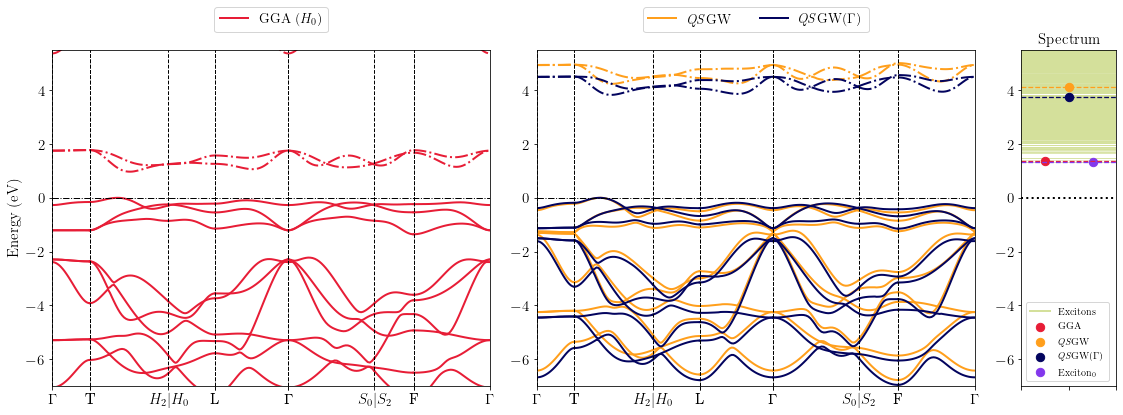

In [60]:
# fig,ax1=plt.subplots(1,2,figsize=(16,6))
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'pdf',
           'axes.labelsize': 12,
           'font.size': 15,
           'axes.titlesize':15,
           'legend.fontsize': 10,
           'xtick.labelsize': 10,
           'ytick.labelsize': 10,
           'text.usetex': True,
           'figure.figsize': fig_size}
plt.rcParams.update(params)

fig, ax1= plt.subplots(1, 3,figsize=(16,6),gridspec_kw={'width_ratios': [6,6, 1.3]})
colors = ["#e71d36","#ff9f1c","#03045e"]

ax=ax1[0]
bp_plot=bp(p_lda).bs_plot_data()
ef=0#np.max(np.array(bp_plot['energy']['1'][0])[10])
for i in range(int(len(bp_plot['distances']))):
    d=bp_plot['distances'][i]
    e=bp_plot['energy']['1'][i]
    e=e-ef
    for k in e:
        if k[0]>0:ls="-."#c="#e9c46a"
        else:ls="-"#c="#e76f51"
        c=colors[0]
        ax.plot(d,k,c=c,lw=2,ls=ls)
        

ax=ax1[1] 
bp_plot=bp(p_gw).bs_plot_data()
ef=0#np.max(np.array(bp_plot['energy']['1'][0])[10])
for i in range(len(bp_plot['distances'])):
    d=bp_plot['distances'][i]
    e=bp_plot['energy']['1'][i]
    e=e-ef
    for k in e:
        if k[0]>0:ls="-."#c="#e9c46a"
        else:ls="-"#c="#e76f51"
        c=colors[1]
        ax.plot(d,k,c=c,lw=2,ls=ls)
        
        
    
bp_plot=bp(p_bse).bs_plot_data()
ef=0#np.max(np.array(bp_plot['energy']['1'][0])[10])
for i in range(len(bp_plot['distances'])):
    d=bp_plot['distances'][i]
    e=bp_plot['energy']['1'][i]
    e=e-ef
    for k in e:
        if k[0]>0:ls="-."#c="#e9c46a"
        else:ls="-"#c="#e76f51"
        c=colors[2]
        ax.plot(d,k,c=c,lw=2,ls=ls,alpha=1)        

for axis in ax1[:2]:
    for j,i in enumerate(bp_plot['ticks']["distance"]):
        axis.axvline(i,c="k",ls="--",lw=1)
    
for j,i in enumerate (ax1[:2]):
    fs=15
    lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in colors]
    labels = ['GGA ($H_0$)', '$\it{QS}$GW','$\it{QS}$GW($\Gamma$)']
    if j==0:
        lines_j=[lines[0]]
        labels_j=[labels[0]]
    else:
        lines_j=lines[1:3]
        labels_j=labels[1:3]
    i.legend(lines_j, labels_j,loc="upper center",fontsize=fs-1, bbox_to_anchor=(0.5, 1.15),
                ncol=3, fancybox=True, shadow=False) 
        # plt.yticks(fontsize=fs)
    i.tick_params(axis='y',labelsize=fs)
    i.set_xticks(bp_plot['ticks']["distance"])
    i.set_xticklabels(bp_plot['ticks']["label"],fontsize=fs)
    i.axhline(0,ls="-.",c="k",lw=1)
    i.set_ylim(-7,5.5)
    i.autoscale(enable=True, axis='x', tight=True)
    if i==ax1[0]:
        i.set_ylabel("Energy (eV)",fontsize=fs)
plot_spectrum(ax1[2],fs=fs)
plt.tight_layout()
plt.savefig("figs/bands_compare.pdf",dpi=300)
plt.show()

In [ ]:
p_lda=get_bands("data/bnds_LDA.temp",coords_are_cartesian=False)

# BSE optical

In [63]:
import re
def get_eps(fname):
    def norm(x):
        return x / np.trapz(x)
    def spectrum(E,osc,sigma,x):
        gE=[]
        for Ei in x:
            tot=0
            for Ej,os in zip(E,osc):
                tot+=os*np.exp(-((((Ej-Ei)/sigma)**2)))
            gE.append(tot)
        return gE
    E=np.loadtxt(fname,comments="#").T
    r=spectrum(E[0],E[2],sigma=.1,x=E[0])
    return [E[0],r]

In [64]:
bse_xy_wlocal=get_eps("data/BSE_withlocal_xy")
bse_z_wlocal=get_eps("data/BSE_withlocal_z")
rpa_xy_wlocal=get_eps("data/RPA_withlocal_xy")
rpa_z_wlocal=get_eps("data/RPA_withlocal_z")

bse_xy_wolocal=get_eps("data/BSE_withoutlocal_xy")
bse_z_wolocal=get_eps("data/BSE_withoutlocal_z")
rpa_xy_wolocal=get_eps("data/RPA_withoutlocal_xy")
rpa_z_wolocal=get_eps("data/RPA_withoutlocal_z")

In [22]:
def plot_dos(ax,fs=14):
    import numba as nb
    with open('./data/Eigenvals_bse') as f:
        evals = np.array([list(map(float, i[2:-2].split(','))) for i in f]).T[0]*13.6056980659
    @nb.jit(parallel=True)
    def spectrum(E,osc,sigma,x):
        gE=[]
        for Ei in x:
            tot=0
            for Ej,os in zip(E,osc):
                tot+=os*np.exp(-((((Ej-Ei)/sigma)**2)))
            gE.append(tot)
        return gE


    # plt.rc('legend',**{'fontsize':14})
    # fig = plt.figure(figsize=(8, 6)) 
    # gs = gridspec.GridSpec(2, 1)

    # ax = plt.subplot(gs[1,0])
    c="#ee6c4d"
    evals=evals[2:]
    x=np.linspace(0,evals.max(),5000)
    y=np.array(spectrum(evals,np.ones(evals.shape),2e-1,x))
    y/=y.max()#np.linalg.norm(y)
    ax.plot(x,y,c=c,lw=1.5)
    ax.fill_between(x,y,color=c,alpha=0.1)
    from matplotlib.collections import LineCollection
    lines=[[[i,0],[i,.1]] for i in evals]
    lc = LineCollection(lines,lw=.05,colors="#e76f51")
    ax.add_collection(lc)
    ax.autoscale() 
    ax.set_xlim([0,11])
    ax.set_ylabel("Exciton DOS")

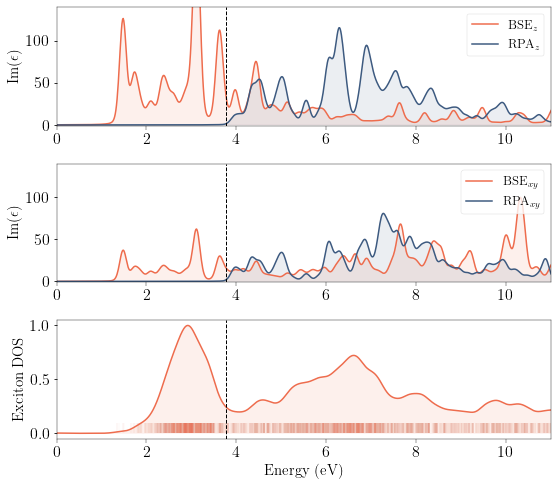

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'pdf',
           'axes.labelsize': 15,
           'font.size': 15,
           'axes.titlesize':15,
           'legend.fontsize': 13,
           'xtick.labelsize': 8*2,
           'ytick.labelsize': 8*2,
           'text.usetex': True,
           'figure.figsize': fig_size}
plt.rcParams.update(params)

fs=10
# plt.rc('legend',**{'fontsize':fs})
fig = plt.figure(figsize=(8, 7),facecolor="w") 
gs = gridspec.GridSpec(3, 1)

ax = plt.subplot(gs[1,0])
data=bse_xy_wlocal
ax.plot(data[0],data[1],c="#ee6c4d",linestyle="-",label="BSE$_{xy}$",lw=1.5)
ax.fill_between(data[0],data[1], color='#ee6c4d',alpha=.1)
data=rpa_xy_wlocal
ax.plot(data[0],data[1],c='#3d5a80',linestyle="-",label="RPA$_{xy}$",lw=1.5)
ax.fill_between(data[0],data[1], color='#3d5a80',alpha=.1)
# ax.set_title("$\perp$ (out of plane)", fontsize=14)
ax.set_xlim([0,11])
ax.set_ylim([-1,140])
ax.legend(loc='upper right')
ax.set_ylabel("Im($\epsilon$)")



ax = plt.subplot(gs[0,0])
data=bse_z_wlocal
ax.plot(data[0],data[1],c="#ee6c4d",linestyle="-",label="BSE$_{z}$",lw=1.5)
ax.fill_between(data[0],data[1], color='#ee6c4d',alpha=.1)
data=rpa_z_wlocal
ax.plot(data[0],data[1],c='#3d5a80',linestyle="-",label="RPA$_{z}$",lw=1.5)
ax.fill_between(data[0],data[1], color='#3d5a80',alpha=.1)
# ax.set_title("$\parallel$ (in-plane)")
ax.set_xlim([0,11])
ax.set_ylim([-1,140])
ax.legend(loc='upper right')
ax.set_ylabel("Im($\epsilon$)")



ax = plt.subplot(gs[2,0])
plot_dos(ax,fs=fs)
# plt.xticks(size = 19)
# plt.yticks(size = 19)
ax.set_xlabel("Energy (eV)")
for i in gs:
    ax = plt.subplot(i)
    ax.axvline(3.7625,c="k",ls="--",lw=1)

plt.tight_layout()
plt.savefig("figs/QSGWG_BSE_RPA.pdf",dpi=300)

# Exciton

In [3]:
with open('./data/Eigenvals_bse') as f:
    evals = np.array([list(map(float, i[2:-2].split(','))) for i in f]).T[0]*13.6056980659

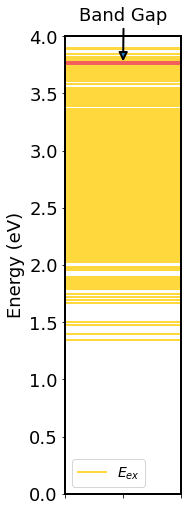

In [321]:

# matplotlib.rcParams.update({'font.size': 18})
# matplotlib.rcParams['axes.linewidth'] = 2
fig2 = plt.figure(figsize=(2.5,7),constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig2)
#plt.scatter(evals,range(len(evals)),s=3)
ax =  fig2.add_subplot(spec2[0, 0])
for i in evals[:1300]:
    ax.axhline(i,c="#FFD83D",alpha=1,lw=2)
ax.axhline(evals[0],c="#FFD83D",alpha=1,lw=2,label="$E_{ex}$")
plt.legend()
ax.axhline(3.7625,c="#f25f5c",linestyle="-",lw=4,alpha=1)
ax.set_ylabel("Energy (eV)")
# ax.fill_between([-1,3],[5,5],[-1,3])
ax.annotate('Band Gap',
            xy=(.5, 3.7625),
            xytext=(.125, 4.1),  
            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3",linewidth=2),
            horizontalalignment='left',
            verticalalignment='bottom',
            )
ax.set_ylim([0,4])
ax.set_xticklabels("")
plt.savefig("figs/Excitons.png",dpi=300)
plt.show()

## 1) Recheck old QSGW + BSE
## 2) Valence to conduction for band band transition 
## 3) Band gap values
## 4) LMF optics bands labeling

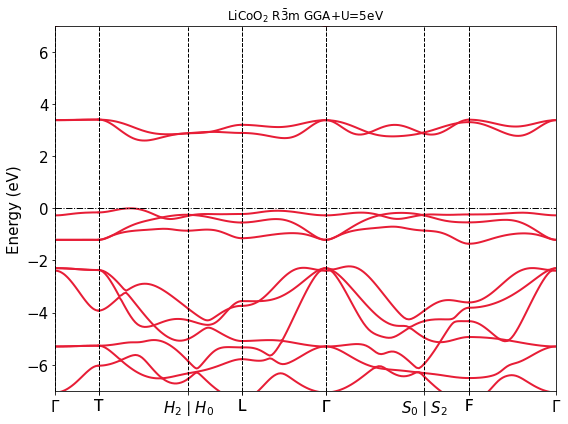

In [25]:
fig, ax1= plt.subplots(1, 1,figsize=(8,6))
colors = ["#e71d36","#ff9f1c","#03045e"]
p_lda=get_bands("data/bnds_LDA.temp",coords_are_cartesian=False)
for i in [p_lda]: 
    i.efermi=list(i.bands.values())[0][10].max()+1e-2
p_lda=p_lda.apply_scissor(2.6)
ax=ax1
bp_plot=bp(p_lda).bs_plot_data()
ef=0#np.max(np.array(bp_plot['energy']['1'][0])[10])
for i in range(int(len(bp_plot['distances']))):
    d=bp_plot['distances'][i]
    e=bp_plot['energy']['1'][i]
    e=e-ef
    for k in e:
        if k[0]>0:ls="-"#c="#e9c46a"
        else:ls="-"#c="#e76f51"
        c=colors[0]
        ax.plot(d,k,c=c,lw=2,ls=ls)
for axis in [ax1]:
    for j,i in enumerate(bp_plot['ticks']["distance"]):
        axis.axvline(i,c="k",ls="--",lw=1)
    
for j,i in enumerate ([ax1]):
    fs=15
    i.tick_params(axis='y',labelsize=fs)
    i.set_xticks(bp_plot['ticks']["distance"])
    i.set_xticklabels(bp_plot['ticks']["label"],fontsize=fs)
    i.axhline(0,ls="-.",c="k",lw=1)
    i.set_ylim(-7,7)
    i.autoscale(enable=True, axis='x', tight=True)
    i.set_ylabel("Energy (eV)",fontsize=fs)
plt.title("LiCoO$_2$ R$\\bar{3}$m GGA+U=5eV")
plt.tight_layout()
plt.savefig("LiCoO2-U-5.png",dpi=300)
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def get_components(fname="data/popt.temp",direction="x"):
    lines = open(fname).read().split('\n')
    r,c=int(lines[0].split(" ")[2]),int(lines[0].split(" ")[4])
    vals=[]
    for i in "  ".join(lines[1:]).split("  "):
        try:
            vals.append(float(i))
        except:
            None
    e=[t*13.605 for t in vals[0::c]]
    vals=np.array(vals)
    l=3
    m=12
    num_bands=int((c-1)/3) 
    vals1=np.arange(1,num_bands +1,1)
    vals_bandsx=[]
    vals_bandsz=[]
    bands=[]
    plot=1
    if plot:
        for i in vals1:
           #y=(vals[i::c]+vals[i+1::c]+vals[i+2::c])/3.
            if direction=="x":
                y=vals[i::c]
                #plt.plot(e,y,label=str(l)+"-"+str(m),alpha=1,lw=1.5)
                vals_bandsx.append(y)

            if direction=="z":
                y=vals[i+num_bands*2::c]
                #plt.plot(e,y,label=str(l)+"-"+str(m),alpha=1,lw=1.5)
                vals_bandsz.append(y)
            bands.append(str(l)+"-"+str(m))    
            l=l+1
            if l==12:
                l=3
                m=m+1

    vals_bands=[]

    fullx=[]
    fullz=[]

    for i in np.arange(1,num_bands +1,1):
        yx=(vals[i::c])
        fullx.append(yx)
        yz=(vals[i+num_bands*2::c])
        fullz.append(yz)
    if direction=="z":
        return e,fullx,fullz,vals_bandsz,bands
    if direction=="x":
        return e,fullz,fullx,vals_bandsx,bands

In [50]:
def plot_optics(ax,direction="x"):
    e,fullx,fullz,vals_bandsz,bands=get_components(fname="../data/popt.temp",direction=direction)
    #Get data
    # data=np.true_divide(vals_bandsz,vals_bandsz.sum(axis=0, keepdims=True))
    data=np.true_divide(vals_bandsz,np.asarray(vals_bandsz).sum(axis=0, keepdims=True))
    n=data.shape[0]-17

    #plot
    fs=12
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["w","#ff6b6b"])
    p=ax.pcolor(e,range(n),data[0:n],cmap=cmap)
    for i in range(n):
        ax.axhline(i,c="k",lw=0.5,ls=":")
    ax.set_yticks(np.arange(len(bands))+0.5)
    ax.set_yticklabels(bands)
    ax.set_ylabel("Band-Band contributions",fontsize=fs)
    cbaxes = inset_axes(ax, width="10%", height="3%", loc=1) 
    cbar=plt.colorbar(p,cax=cbaxes, ticks=[0.,1], orientation='horizontal')
    cbar.set_ticklabels(["$0\%$","$100\%$"])
    #uncomment for showing the band values in text
    # for j,i in enumerate(np.arange(n-1)+0.4):
    #     ax.text(3.5,i,bands[j],ha='center', va='center')
    # ax.set_yticks(np.arange(n)+0.5)
    # ax.set_yticklabels([])  

    #plot variable
    ax1 = ax.twinx()
    if direction=="x":
        lab="xy"
    else:
        lab="z"
    ax1.plot(e,np.sum(np.array(fullx),axis=0),c="k",lw=1.4,label="Im($\epsilon$)$_{"+lab+"}$")
    ax1.set_ylim(ymin=0,ymax=37)
    ax1.set_ylabel("Im($\epsilon$)",fontsize=fs)
    ax1.legend(loc="center right")
    

    ax.set_ylim(0,n-1)
    ax.set_xlim(3.8,13)
    ax.set_xlabel("Energy (eV)")

def plot_bands_withnumber(ax):
    colors = ["#ff9f1c","#e71d36","#14213d"]
    # bp_plot=bp(p_gw).bs_plot_data()
    from questaal_reader import get_bands
    from pymatgen.electronic_structure.plotter import BSPlotter as bp
    p_gw=get_bands("data/bnds_gw.temp",coords_are_cartesian=False)
    bp_plot=bp(p_gw).bs_plot_data()
    bp_plot
    ef=np.max(np.array(bp_plot['energy']['1'][0])[10])
    for i in range(len(bp_plot['distances'])):
        d=bp_plot['distances'][i]
        e=bp_plot['energy']['1'][i]
        e=e
        for ki,k in enumerate(e):
            if k[0]>0:ls="-."#c="#e9c46a"
            else:ls="-"#c="#e76f51"
            c=colors[1]
            plt.plot(d,k,c=c,lw=1.4,ls=ls)
            if i==range(len(bp_plot['distances']))[-1] and ki<=12 and ki>1:
                n=np.random.randint(10,len(d))
                ax.text(d[n],k[n], str(ki+1), size=10.,
                 ha="right", va="top",
                 bbox=dict(boxstyle="square",
                           ec=(0,0,0),
                           fc=(1., 1, 1),
                           )
                 )
    
    for j,i in enumerate(bp_plot['ticks']["distance"]):
        ax.axvline(i,c="k",ls="--",lw=1)

    fs=12

#     plt.yticks(fontsize=fs)
    ax.set_xticks(bp_plot['ticks']["distance"])
    ax.set_xticklabels(bp_plot['ticks']["label"],fontsize=fs)
    ax.axhline(0,ls="-.",c="k",lw=1)
    ax.set_ylim(-7,6)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_ylabel("Energy (eV)",fontsize=fs)

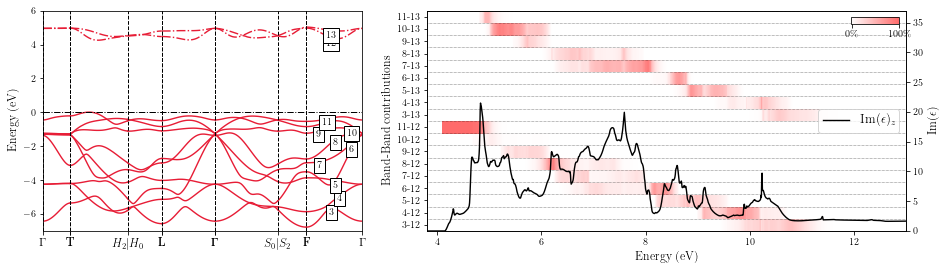

In [52]:
from matplotlib import gridspec
np.random.seed(35)#7,35 is good

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {'backend': 'pdf',
           'axes.labelsize': 12,
           'font.size': 15,
           'axes.titlesize':15,
           'legend.fontsize': 13,
           'xtick.labelsize': 10,
           'ytick.labelsize': 10,
           'text.usetex': True,
           'figure.figsize': fig_size}
plt.rcParams.update(params)


fig = plt.figure(figsize=( 482.*2/72., 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5]) 
ax = plt.subplot(gs[1])
plot_optics(ax,direction="z")

ax = plt.subplot(gs[0])
plot_bands_withnumber(ax)

plt.tight_layout()
plt.savefig("figs/band-band-transition-z.pdf",dpi=300)
plt.show()

In [69]:
rpa_xy_wlocal=get_eps("data/RPA_withlocal_xy")
rpa_z_wlocal=get_eps("data/RPA_withlocal_z")
rpa_xy_wolocal=get_eps("data/RPA_withoutlocal_xy")
rpa_z_wolocal=get_eps("data/RPA_withoutlocal_z")


In [96]:
fig_width_pt = 1.5*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fig,ax1=plt.subplots(2,1,figsize=(fig_width,5))
e,lmf_z,_,_,_=get_components(fname="../data/popt.temp",direction="x")
e,lmf_x,_,_,_=get_components(fname="../data/popt.temp",direction="z")
lmf_x=np.sum(np.array(lmf_x),axis=0)
lmf_z=np.sum(np.array(lmf_z),axis=0)

ax=ax1[0]
ax.plot(e,lmf_x,label="lmf x",c="#f94144",lw=1.5)
ax.fill_between(e,lmf_x,color="#f94144",lw=1.5,alpha=0.1)
ax.plot(e,lmf_z,label="lmf z",c="#277da1",lw=1.5)
ax.fill_between(e,lmf_z,color="#277da1",lw=1.5,alpha=0.1)

ax=ax1[1]
data=rpa_xy_wlocal
ax.plot(data[0],data[1],c="#f94144",label="RPA$_{xy}$",lw=1.5)
ax.fill_between(data[0],data[1],color="#f94144",lw=1.5,alpha=0.1)
data=rpa_z_wlocal
ax.plot(data[0],data[1],c="#277da1",label="RPA$_{z}$",lw=1.5)
ax.fill_between(data[0],data[1],color="#277da1",lw=1.5,alpha=0.1)

for j,i in enumerate(ax1):
    i.legend()
    i.set_xlim(3.5,12)
    i.set_ylabel("Im($\epsilon$)")
    i.set_ylim(0,None)
    if j>0:
        i.set_xlabel("Energy (eV)")
plt.tight_layout()
plt.savefig("figs/rpa-compare.pdf",dpi=300)
plt.show()